9-4 네거티브 샘플링을 이용한 Word2Vec 구현(SGNS)

1. 네거티브 샘플링(Negative sampling)

Word2Vec의 출력층에서는 소프트맥스 함수를 지닌 단어 집합 크기의 벡터와 실제값인 원-핫 벡터와의 오차를 구하고 임베딩 테이블에 있는 모든 단어에 대한 임베딩 벡터 값을 업데이트한다.\
만약 단어 집합의 크기가 크다면 학습하는데 오래 걸린다는 단점이 존재한다.

네거티브 샘플링은 Word2Vec이 학습 과정에서 전체 단어 집합이 아니라 일부 단어 집합에만 집중하는 방법이다.\
if 주변 단어가 '강아지','귀여운' 일때, 여기에 '돈가스','컴퓨터','회의실'과 같은 단어 집합에서 무작위로 선택된 주변단어가 아닌 단어들을 일부 가져온다.\
하나의 중심 단어에 대해서 전체 단어 집합보다 훨씬 작은 단어 집합을 만들고 마지막 단계를 이진 분류 문제로 변환한다.\
주변 단어들을 긍정(Positive), 랜덤으로 샘플링 된 단어들을 부정(Negative)로 레이블링한다면 이진 분류 문제를 위한 데이터셋이 된다.

2. 네거티브 샘플링 Skip-man(SGNS)

앞서 배운 Skip-gram(중심 단어로부터 주변 단어를 예측하는 모델)\
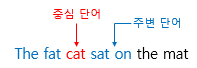\
ex) 중심단어 cat으로 부터 주변단어 The,fat,sat,on을 예측한다.\
아래의 그림은 Skip-gram을 주황 박스로 생각하는데, 이때 입력은 중심단어, 모델의 예측은 주변 단어가 되는 구조가 된다.\
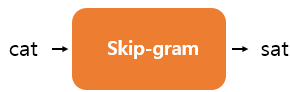\
하지만 네거티브 샘플링을 사용하는 Skip-gram(이하 SGNS)은 위와는 다른 접근 방식을 취한다.\
SGNS는 중심 단어와 주변 단어가 모두 입력이 되고, 이 두 단어가 실제로 윈도우 크기 내에 존재하는 이웃 관계인지 확률을 예측한다.\
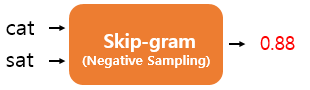

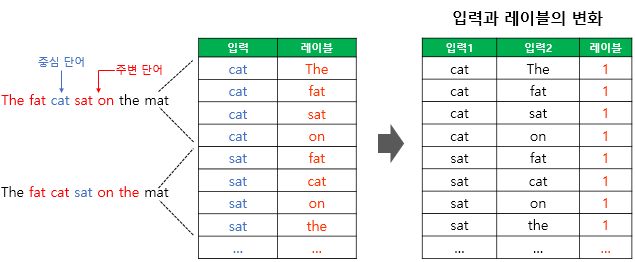\
좌측의 레이블은 기존 Skip-gram을 학습하기 위한 데이터셋이다. Skip-gram은 기본적으로 중심 단어를 입력하고 주변 단어를 레이블로 한다\
하지만 SGNS를 학습하려면 우측의 레이블처럼 수정해야한다.\
기존의 Skip-gram 데이터셋에서 중심 단어와 주변 단어를 입력1,2로 둔다. 이 둘은 실제로 윈도우 크기 내에서 이웃 관계였기 때문에 레이블은 1로 한다. 그 후 레이블이 0인 샘플을 준비한다.

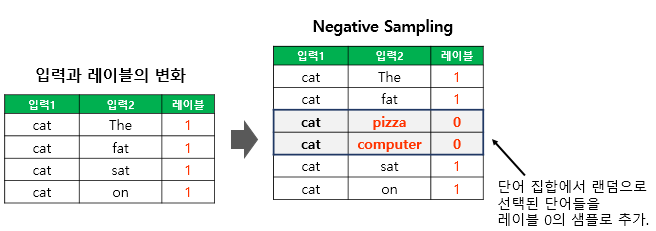\
입력1(중심 단어)과 주변 단어 관계가 아닌 단어 집합에서 랜덤으로 선택한 단어들을 입력2로 하고, 레이블을 0으로 지정한다.\
즉, 입력1과2의 관계가 실제 윈도우 크기 내에서 이웃 관계면 레이블이 1, 아니라면 레이블이 0인 데이터셋이 완성된다.\
그리고 이제 두 개의 임베딩 테이블을 준비한다. 두 임베딩 테이블은 훈련 데이터의 단어 집합의 크기를 가지므로 크기가 같다.

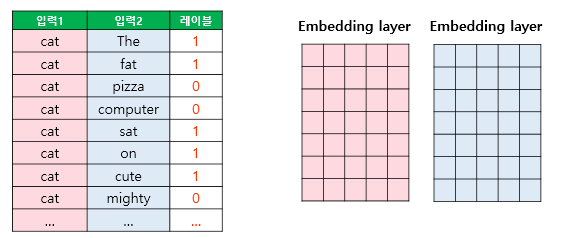\
두 테이블 중 하나는 입력 1(중심 단어)의 테이블 룩업을 위한 임베딩 테이블이고, 하나는 입력 2(주변 단어)의 테이블 룩업을 위한 임베딩 테이블이다.\
각 단어는 임베딩 테이블을 테이블 룩업하여 임베딩 벡터로 변환된다.

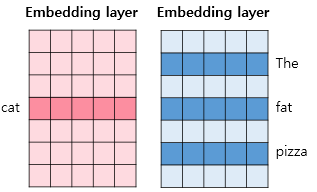\
각 임베딩 테이블을 통해 테이블 룩업하여 임베딩 벡터로 변환되었다면 그 후의 연산은 매우 간단하다.\
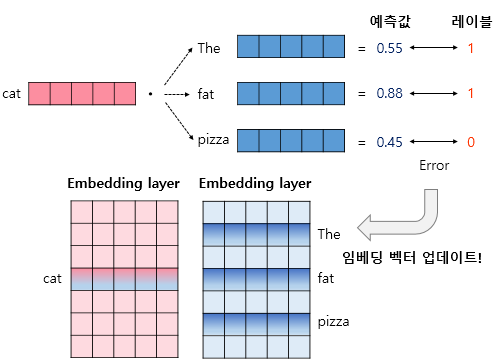\
중심 단어와 주변 단어의 내적값을 모델의 예측값으로 하고, 레이블과의 오차로부터 역전파하여 중심 단어와 주변 단어의 임베딩 벡터값을 업데이트한다.\
학습 후에는 좌측의 임베딩 행렬을 임베딩 벡터로 사용할 수도 있고, 두 행렬을 더한 후 사용하거나 두 행렬을 연결해서 사용할수도 있다.\
아래 실습에서는 좌측의 행렬을 사용하는 방식을 이용한다.

3. 20뉴스 그룹 데이터 전처리하기

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
print('총 샘플 수 :',len(documents))

총 샘플 수 : 11314


In [3]:
news_df = pd.DataFrame({'document':documents})
# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ",regex=True) # 영어를 제외한 나머지 단어 공백 처리
# 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

In [4]:
news_df.isnull().values.any()

False

In [5]:
# 빈 값을 Null로 바꾼후 확인
news_df.replace("", float("NaN"), inplace=True)
news_df.isnull().values.any()

True

In [6]:
news_df.dropna(inplace=True)
print('총 샘플 수 :',len(news_df))

총 샘플 수 : 10995


In [7]:
# 불용어 제거
stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

In [8]:
# 단어가 1개 이하인 샘플의 인덱스를 찾아서 저장하고, 해당 샘플들은 제거.
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
print('총 샘플 수 :',len(tokenized_doc))

총 샘플 수 : 10940


C:\Users\rladu\anaconda3\envs\my_env\lib\site-packages\numpy\lib\function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {value : key for key, value in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [10]:
print(encoded[:2])

[[9, 59, 603, 207, 3278, 1495, 474, 702, 9470, 13686, 5533, 15227, 702, 442, 702, 70, 1148, 1095, 1036, 20294, 984, 705, 4294, 702, 217, 207, 1979, 15228, 13686, 4865, 4520, 87, 1530, 6, 52, 149, 581, 661, 4406, 4988, 4866, 1920, 755, 10668, 1102, 7837, 442, 957, 10669, 634, 51, 228, 2669, 4989, 178, 66, 222, 4521, 6066, 68, 4295], [1026, 532, 2, 60, 98, 582, 107, 800, 23, 79, 4522, 333, 7838, 864, 421, 3825, 458, 6488, 458, 2700, 4730, 333, 23, 9, 4731, 7262, 186, 310, 146, 170, 642, 1260, 107, 33568, 13, 985, 33569, 33570, 9471, 11491]]


In [11]:
vocab_size = len(word2idx) + 1
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 64277


총 64,277개의 단어가 존재한다.

4. 네거티브 샘플링을 통한 데이터셋 구하기

In [12]:
from tensorflow.keras.preprocessing.sequence import skipgrams
# 네거티브 샘플링
skip_grams = [skipgrams(sample, vocabulary_size = vocab_size, window_size = 10) for sample in encoded[:10]]

In [13]:
# 첫번째 샘플인 skip_grams[0] 내 skipgrams로 형성된 데이터셋 확인
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          idx2word[pairs[i][0]], pairs[i][0], 
          idx2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(letter (705), described (984)) -> 1
(daily (1920), government (51)) -> 1
(media (702), daydream (33237)) -> 0
(israeli (442), report (581)) -> 1
(shame (4988), might (52)) -> 1


윈도우 크기 내에서 중심 단어, 주변 단어의 관계를 가지는 경우에는 1의 레이블을 갖도록 하고, 그렇지 않은 경우는 0의 레이블을 가지도록 하여 데이터셋을 구성한다.

In [14]:
print('전체 샘플 수 :',len(skip_grams))

전체 샘플 수 : 10


In [15]:
# 첫번째 뉴스 그룹 샘플에 대해서 생긴 pairs와 labels의 계수
print(len(pairs))
print(len(labels))

2220
2220


In [16]:
skip_grams = [skipgrams(sample, vocabulary_size = vocab_size, window_size = 10) for sample in encoded]

5. Skip-Gram with Negative Sampling(SGNS) 구현하기

In [17]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

하이퍼 파라미터인 임베딩 벡터의 차원은 100으로 정하고, 두 개의 임베딩 층을 추가한다.

In [18]:
embedding_dim = 100

# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype = 'int32')
word_embedding = Embedding(vocab_size, embedding_dim)(w_inputs)

# 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype = 'int32')
context_embedding = Embedding(vocab_size, embedding_dim)(c_inputs)

각 임베딩 테이블은 중심 단어와 주변 단어 각각을 위한 임베딩 테이블이며 각 단어는 임베딩 테이블을 거쳐서 내적을 수행하고,\
내적의 결과는 1 또는 0을 예측하기 위해서 시그모이드 함수를 활성화 함수로 거쳐 최종 예측값을 얻는다.

In [19]:
dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape = (1,1))(dot_product)
output = Activation('sigmoid')(dot_product)

model = Model(inputs = [w_inputs, c_inputs], outputs = output)
model.summary()
model.compile(loss = 'binary_crossentropy', optimizer = 'adam')
plot_model(model, to_file = 'model3.png', show_shapes = True, show_layer_names = True, rankdir = 'TB')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 100)       6427700     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 100)       6427700     ['input_2[0][0]']                
                                                                                              

In [20]:
for epoch in range(1, 6):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)  
    print('Epoch :',epoch, 'Loss :',loss)

Epoch : 1 Loss : 4631.224238075316
Epoch : 2 Loss : 3678.416909687221
Epoch : 3 Loss : 3520.6123240701854
Epoch : 4 Loss : 3313.041897587478
Epoch : 5 Loss : 3085.857800547499


6. 결과 확인하기

학습된 임베딩 벡터들을 vector.txt에 저장한다. 그 후 이를 gensim의 models.KeyedVectors.load_word2vec_format()으로 로드 가능하다.

In [23]:
import gensim

f = open('vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

# 모델 로드
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

NameError: name 'embed_size' is not defined